In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import BertTokenizerFast
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from langchain.embeddings import HuggingFaceEmbeddings
from torch.utils.data import Dataset
import lightning as pl
import torch
from torch import nn
from torch.functional import F

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stephan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# load dataset

In [2]:
df_train = pd.read_parquet("data/train.parquet")
df_test = pd.read_parquet("data/test.parquet")

In [3]:
df_train

,text,label
0,"Wo werden Aufzüge getestet, die sich senkrecht...",question
1,Was versteht man unter Aperzeit in der alpinen...,question
2,Wie hieß der Militäreinsatz der USA in Afghani...,question
3,Was sind die ältesten Indianer Funde in Alaska?,question
4,Welche Regionen in Guinea-Bissau sind mehrheit...,question
...,...,...
1069,Ich habe 5 Stunden studiert und bin trotzdem n...,concern
1070,"Ich habe nur das Gefühl, dass die Schule zu ha...",concern
1071,"Ich habe mir nur Sorgen gemacht, ob ich meinen...",concern
1072,Die Schule hat sich verschleppt und ich habe s...,concern


# EDA

## Verteilung der Klassend und Anzahl Wörter

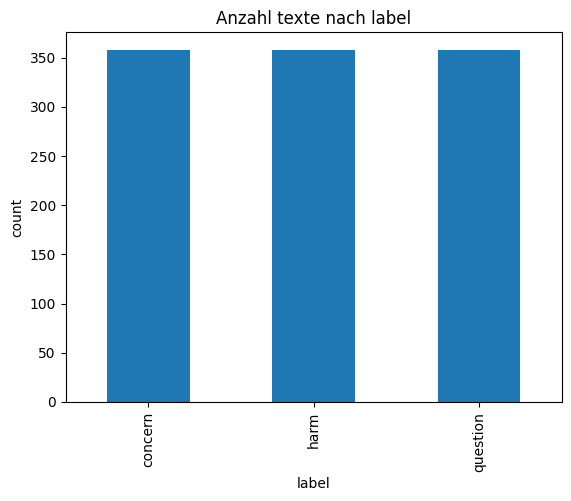

In [4]:
df_train.groupby("label").size().plot.bar()
plt.xlabel("label")
plt.ylabel("count")
plt.title("Anzahl texte nach label")
plt.show()

In diesem Plot ist zu erkennen, dass jede Gruppe (label) im train-set gleich vertreten ist.

In [5]:
df_train

,text,label
0,"Wo werden Aufzüge getestet, die sich senkrecht...",question
1,Was versteht man unter Aperzeit in der alpinen...,question
2,Wie hieß der Militäreinsatz der USA in Afghani...,question
3,Was sind die ältesten Indianer Funde in Alaska?,question
4,Welche Regionen in Guinea-Bissau sind mehrheit...,question
...,...,...
1069,Ich habe 5 Stunden studiert und bin trotzdem n...,concern
1070,"Ich habe nur das Gefühl, dass die Schule zu ha...",concern
1071,"Ich habe mir nur Sorgen gemacht, ob ich meinen...",concern
1072,Die Schule hat sich verschleppt und ich habe s...,concern


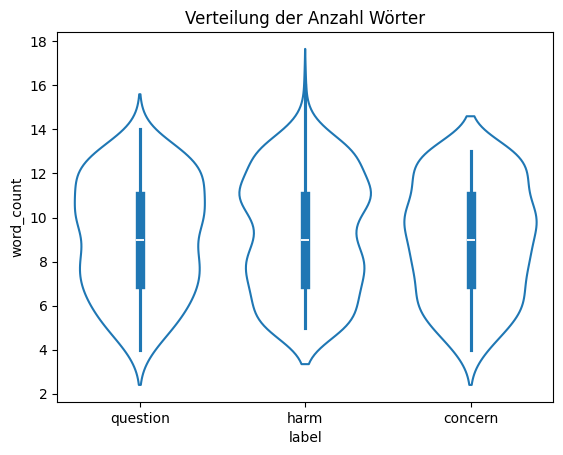

In [6]:
sns.violinplot(df_train.assign(word_count=df_train['text'].apply(lambda x: len(x.split(" "))))[["label", "word_count"]], x="label", y="word_count", fill=False) 
plt.title("Verteilung der Anzahl Wörter")
plt.show()

Um herauszufinden, wie die Wortverteilung pro Klasse aussieht, wurde jeweils die Anzahl Wörter im Text gezählt und anschliessend ein Violinplot visualisiert.<br>
Dieser Plot zeigt, dass die Verteilung nach Klasse ungefär gleich ist. Median sowie Q1 und Q2 sind etwa am gleichen Ort und die Violinen zeigt auch eine ähnliche Verteilung.

## Text qualitative

In [7]:
for label, df in df_train.groupby("label"):
    print(label + ":")
    display(df.sample(10, random_state=1).text.to_list())

concern:


['Die Schule macht mich verrückt.',
 'Ich muss einen B- bekommen, um einen A zu bekommen.',
 'Ich habe heute einen Test, für den ich nicht wirklich gelernt habe.',
 'Änderungen in meinem Arbeits- und Schulplan aufgrund von COVID 19',
 'Ich habe meine Hausaufgabe für Amerikanistik nicht fertiggestellt. Ich war gestern zu müde.',
 'Ich hatte gerade dieses riesige Projekt und ich musste eine Rede darüber halten!',
 'Es fällt mir schwer, wieder in der Schule zu sein.',
 'Was bedeutet, dass ich zurück zur Schule muss.',
 'Ich muss meinen Abschluss aufschreiben.',
 'Ich habe gestern bei den Tests und Quiz-Dingen definitiv nicht so gut abgeschnitten.']

harm:


['Was für eine hohle Type....',
 'Der nächste der mich meldet den zieh ich nackt realtalk',
 'Das sind keine Franzosen sondern Einwanderer aus einer kuh wird auch kein hund',
 'jahre für das Schwein ist schon ok...alles besser als Bewährung...',
 'EUFaschismus Scootergate Sämtliche deutsche MSM wieder mal beim Arschlecken des ukrainischen Putschregimes',
 'Es gibt deutsche Weiber die sind geil drauf...deswegen wählen sie SPDund Grünen..!',
 'Kurz lasst dich nicht von der Trulla aufs Glatteis führen!',
 'Abnehmen hat sich nicht gelohnt...fett weg Hirn weg...!',
 'So kennen wir die Antifantenbrut! ',
 'Afrikaner nach Afrika LBR Europäer nach Europa LBR So einfach ist das']

question:


['Was ist das Empanada? ',
 'Was dient der Schnabelkomponente des Magnetsinns bei Vögeln als Orientierung?',
 'Wie heißt der Teil des Thorax bei Insekten, an dem die Flügel sitzen?',
 'Aus welchem Grund ist der Hauptbahnhof Utrechts von großer Bedeutung?',
 'Wie viel Mal hat die Schweiz einen Sieg im Eurovision Song Contest errungen?',
 'Seit wann können Videos auf youtube auch eine Bildfrequenz von 60 haben? ',
 'Wie viele Einwohner Nordkoreas sind wegen der US-amerikanischen Luftangriffe gestorben?',
 'Mit welcher Methode wird Zinkoxid aus Zinksulfid-Erzen gewonnen?',
 'Wer hat Samurai bezahlt? ',
 'Wie hoch ist die oberste geologische Schicht in der Region um Miami?']

Wie man erkennen kann, sind die Klassen `concern` und `question` auf diesen Beispielen grammatikalisch Korrekt.<br>
Die Klasse `harm` allerdings hat einige Fehler:
- Leerschläge wurden vergessen
- grammatikalische Fehler
- repetitionen von Satzzeichen

## Tokenization

In [8]:
# Erstellen Sie einen neuen WordPiece-Tokenizer
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

# Erstellen Sie einen neuen WordPiece-Trainer
trainer = WordPieceTrainer(
    special_tokens=["[UNK]"],
)

#train
tokenizer.train_from_iterator(df_train.text.tolist(), trainer)

Damit nicht jedes Wort mit all seinen möglichen Variationen als einzelne Tokens abgespeichert werden müssen, verwenden wir nun den WordPiece Tokenizer.<br>
Statt ein ganzes Wort einem Token zuzuweisen, spaltet er möglicherweise ein Wort in Wortstücke (Wordpieces) auf, wobei immer das erste Subword normal und die anschliessenden Subwords mit einem `##` Prefix versehen sind.<br>
Dies hat den Vorteil, dass eine seltene Wortkombination trotzdem Tokenisiert werden kann und nicht ein `[UNK]` Token verwendet werden muss.<br>
Das erste Subword ohne `##` könnte somit der Wortstamm sein und die nachfolgenden Tokens die Endung eines Wortes.

In [9]:
print("Vocab Size:")
print(tokenizer.get_vocab_size())
print("Vocab:")
print(tokenizer.get_vocab())
print("Beispiel:")
print(tokenizer.encode("Wer ist Dozent beim EDA Modul?").tokens)

Vocab Size:
7559
Vocab:
{'Osmanischen': 6741, 'vorstellen': 5031, '##ts': 1600, '##det': 518, 'Präsidenten': 1868, 'Stadium': 5772, 'recher': 5160, '##atzrechte': 6346, '##bte': 4046, 'Jer': 3228, '##cking': 4528, 'Daten': 3139, 'merkwürdig': 7543, '##maten': 2342, '##schi': 4290, '##dl': 3768, 'Berichterst': 2769, 'Löchern': 6686, '##denunzierenverleum': 7064, 'innen': 4387, 'Zum': 2150, '##ellt': 694, '##iel': 532, 'kann': 331, 'drei': 3507, 'Kompanie': 7502, '##asi': 2441, 'Gutmensch': 5849, 'inten': 4385, '##tel': 3743, 'Mitglieder': 5996, 'Synchron': 5420, '##liche': 597, '##EHO': 4174, 'so': 256, 'bitte': 3497, '##Men': 4186, 'auszu': 4771, 'hässlich': 5915, 'Abschlussnote': 5014, 'Spiele': 5094, '"': 2, '##olreg': 4462, 'Abschlussarbeiten': 5986, '##utzung': 5544, 'festgestellt': 6248, '##sse': 651, '##halts': 5440, 'Gesetzgeb': 5576, 'Satanas': 6510, 'Linksradikalen': 3036, 'Freunde': 6617, 'mast': 3606, 'Irgendwie': 5698, 'Amerikanistik': 7297, '##00': 2385, 'Wind': 1537, 'ARD

Hier wurde das Vokabular basiert auf unserem Training-copus erstellt.<br>
Es ist zu sehen, dass das Vokabular nicht wirklich gross ist, was uns später Probleme bereiten könnte.<br>
Unser Beispielsatz wurde in zu viele einzelne Tokens aufgesplittet. Beispielsweise das Wort Dozent macht nicht viel Sinn in einzelne Subwords aufgesplittet zu werden. 

In [10]:
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-german-cased")

print("Vocab Size:")
print(len(tokenizer.get_vocab()))
print("Vocab:")
print(tokenizer.get_vocab())
print("Beispiel:")
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("Wer ist Dozent beim EDA Modul?", add_special_tokens=False)))

Vocab Size:
31102
Vocab:
{'Administrador': 24378, 'Act': 17222, 'die': 128, '##ätten': 15218, '##ücher': 14381, 'weich': 22073, 'gegen': 574, 'Krieg': 2189, '®': 22638, 'Staatsangehör': 23032, '##utes': 19017, 'ie': 4359, '##emeister': 17590, 'Bier': 6263, '##2010': 6118, 'nes': 30804, '##wig': 2817, 'dortigen': 11838, '##kohol': 5887, 'Medaille': 19053, 'hoher': 8484, 'oftmals': 15233, '##fragt': 6333, '##arin': 19227, 'entfielen': 28448, '##orgt': 4266, 'Eurozone': 27370, 'meldet': 23104, 'Champion': 14626, 'Rätsel': 22545, 'Scha': 30433, '(2)': 3856, '##messungen': 17005, 'system': 8221, 'Wich': 13334, 'fürchten': 22147, 'Berliner': 4516, '##tan': 13892, '##isieren': 7232, 'renov': 13794, '##stäbe': 28814, '##itels': 15287, 'Graph': 21634, '##decken': 6675, 'Sätzen': 25594, 'need': 26716, '##je': 1591, 'Umfragen': 25263, '##oesterreich': 30014, 'nördlichen': 9627, '##takt': 3044, '##rats': 5312, 'Modelle': 10970, '##iteratur': 16115, 'Cin': 18301, '##sache': 13886, 'mde': 17317, 'to

Deshalb wurde nochmals ein pre-trained Tokenizer verwendet.<br>
Der `dbmdz/bert-base-german-cased` tokenizer wurde auf deutschem Text trainiert.<br>
Das Vokabular ist nun um einiges grösser und auch die Tokens des Beispiels machen mehr Sinn.<br>
Ausser EDA wurden die Wörter zusammen gelassen.<br>

In [11]:
print("Beispiel:")
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("Der Kraftfahrzeug-Haftpflichtversicherungstarif ist dieser Tage sehr hoch.", add_special_tokens=False)))

Beispiel:
['Der', 'Kraftfahrzeug', '-', 'Haft', '##pflicht', '##versicherungs', '##tarif', 'ist', 'dieser', 'Tage', 'sehr', 'hoch', '.']


Auch anhand dieses Beispiels kann man erkennen, dass das Wort `Haftpflichtversicherungstarif` in logische Subwords aufgespaltet wurde.<br>

Des weiteren wird ersmals der Pretrained-tokenizer verwendet, da dieser semantisch sinvollere Tokens generiert.

## Wordclouds

c:\Users\Stephan\anaconda3\envs\chatbot-text_classification\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


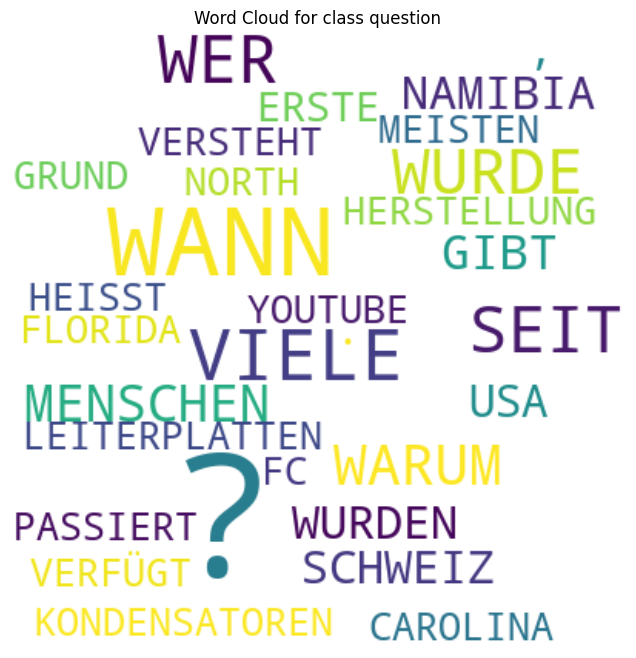

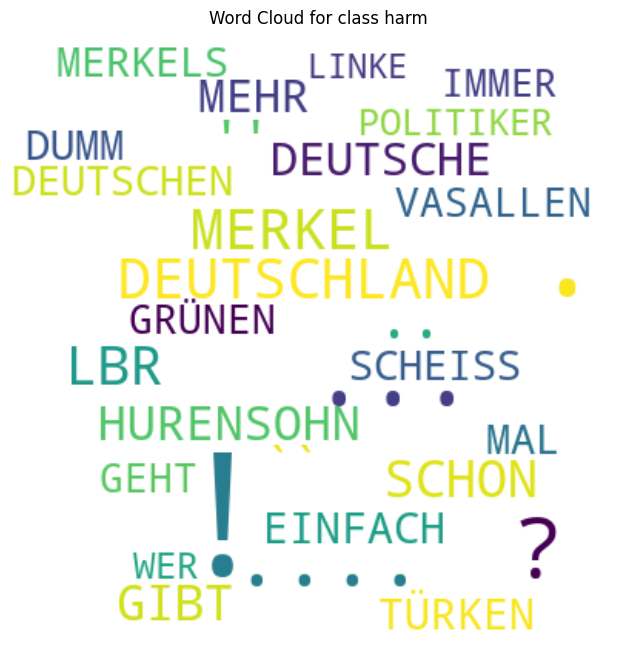

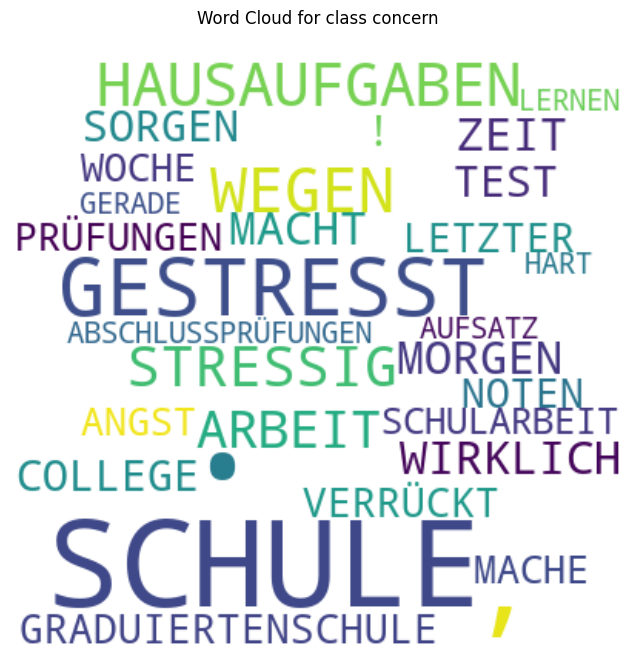

In [12]:
def generate_count_wordclouds(df:pd.DataFrame, top_n_words=50, tokenizer=word_tokenize):
    df = df.copy()
    
    # Erstellen des Tfidf Vectorizers, unter Ausschluss der deutschen Stop-Wörter
    vectorizer = TfidfVectorizer(use_idf=False, norm='l1', stop_words=stopwords.words('german'), tokenizer=tokenizer)
    
    labels = df['label'].unique()

    for label in labels:
        class_data = df[df['label'] == label]
        text_data = class_data['text']
        
        # Anwenden des Tfidf Vectorizers
        word_count_vector = vectorizer.fit_transform(text_data)
        sum_words = word_count_vector.sum(axis=0)
        
        words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        
        # Auswahl der Top-N-Wörter
        top_words_dict = {k.upper(): v for k, v in words_freq[:top_n_words]}
        
        wordcloud = WordCloud(
            width=400,
            height=400,
            random_state=21,
            max_font_size=110,
            background_color='white',
            prefer_horizontal=1,
        ).generate_from_frequencies(top_words_dict)
        
        plt.figure(figsize=(15, 8))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f'Word Cloud for class {label}')
        plt.show()

generate_count_wordclouds(df_train, 30)

Anhand der wordclouds lässt sich erkennen, dass in der Klasse `question` häufig Fragewörter verwendet wurden.<br>
Auch das Fragezeichen ist ein wichtiger Indikator auf eine Frage. Allerdings ist es möglich, dass das Modell sich auf dieses Overfitted.<br>

Bei der Klasse `harm` kann man öfters Wörter im Bezug auf Politik (Merkel, Linke, Grüne, Politiker usw) und Beleidigungen (Hurensohn, Scheiss, usw).<br>

Bei der Klasse `concern` kommen öfters Wörter im Zusammenhang mit Schule vor sowie Wörter, welche sich auf Stress und Angst beziehen.

## Topic modelling

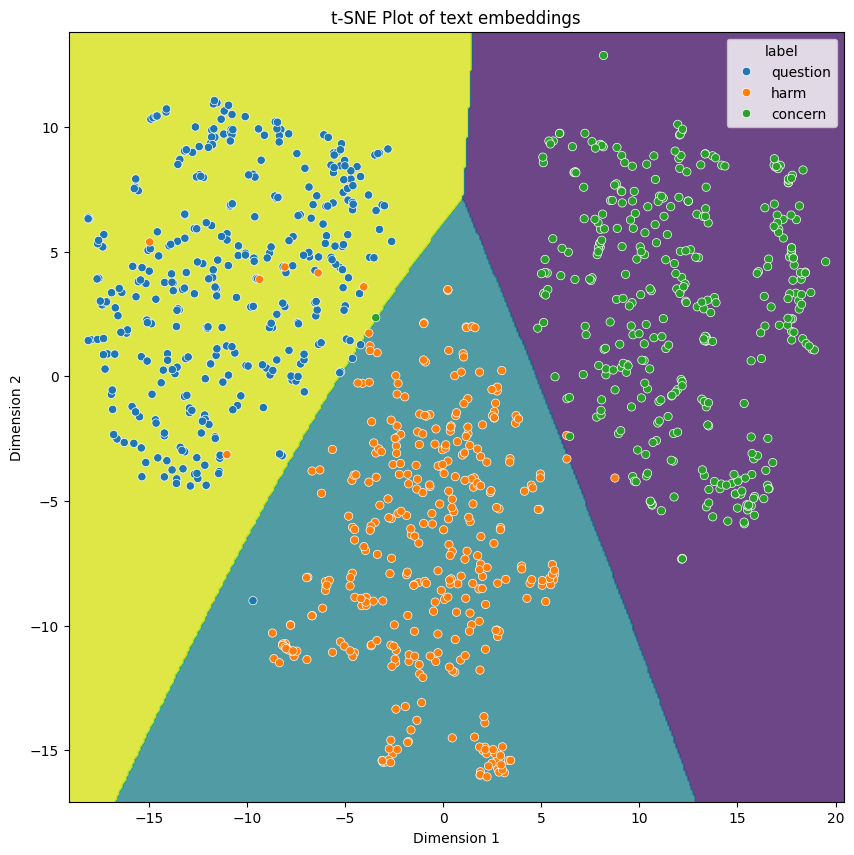

Number of wrong predictions:  12


In [32]:
def tsne_reduction(df:pd.DataFrame, pca_dim=50, perplexity=30, learning_rate=200, seed=1234):
    #make a copy
    df = df.copy()

    #create embeddings
    embeddings = np.array(HuggingFaceEmbeddings(model_name="sentence-transformers/distiluse-base-multilingual-cased-v1").embed_documents(df.text.to_list()))

    # Cimensionality reduction
    pca = PCA(n_components=pca_dim, random_state=seed)
    pca_result = pca.fit_transform(embeddings)
    
    # applyt-SNE
    tsne = TSNE(perplexity=perplexity, learning_rate=learning_rate, n_iter=300, random_state=seed)
    tsne_result = tsne.fit_transform(pca_result)

    #only select dim1 and dim2
    df[["dim1", "dim2"]] = tsne_result[:, :2]

    # apply QDA
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(tsne_result, df.label)  # assuming df has a column named 'label' containing the class labels
    qda_classes = qda.predict(tsne_result)
    
    # add QDA classes to dataframe
    df['qda_class'] = qda_classes

    # Create mesh
    x_min, x_max = df['dim1'].min() - 1, df['dim1'].max() + 1
    y_min, y_max = df['dim2'].min() - 1, df['dim2'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predict mesh and convert labels to numeric
    Z = LabelEncoder().fit_transform(qda.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    return df, (xx, yy, Z)

df, (xx, yy, Z) = tsne_reduction(df_train)

# plot
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, Z, alpha=0.8)
sns.scatterplot(df, x="dim1", y="dim2", hue="label")
plt.title('t-SNE Plot of text embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

print("Number of wrong predictions: ", (df.label != df.qda_class).sum())

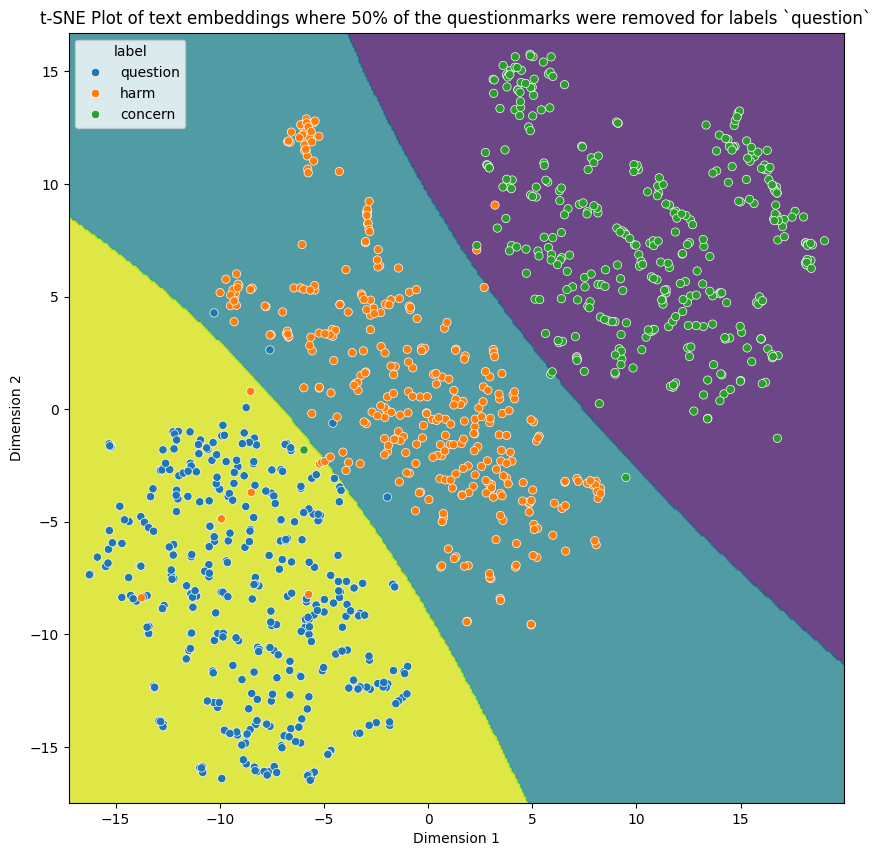

Number of wrong predictions:  18


In [33]:
df_train_questionmark_reduced = df_train.copy()

# delete 50% of the questionmarks from the questions
question_rows = df_train_questionmark_reduced[df_train_questionmark_reduced['label'] == "question"]
random_selection = question_rows.sample(frac=0.5, random_state=1)
df_train_questionmark_reduced.loc[random_selection.index, 'text'] = random_selection['text'].str.replace('?', '')

df, (xx, yy, Z) = tsne_reduction(df_train_questionmark_reduced)

# plot
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, Z, alpha=0.8)
sns.scatterplot(df, x="dim1", y="dim2", hue="label")
plt.title('t-SNE Plot of text embeddings where 50% of the questionmarks were removed for labels `question`')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

print("Number of wrong predictions: ", (df.label != df.qda_class).sum())

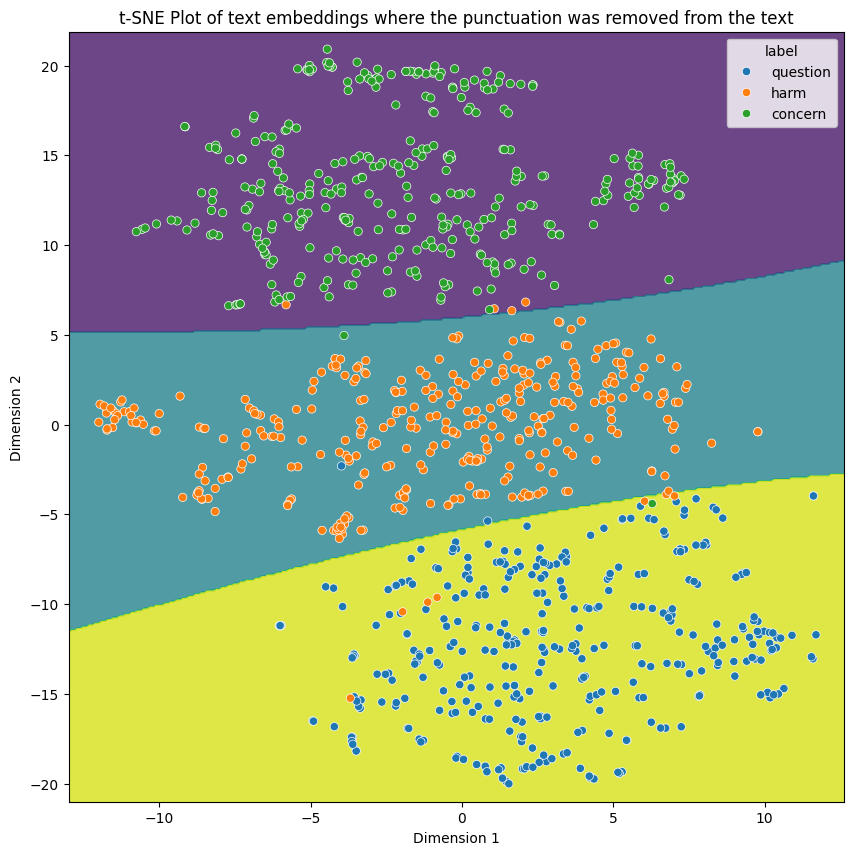

Number of wrong predictions:  15


In [37]:
df_train_no_punktuation = df_train.copy()
df_train_no_punktuation['text'] = df_train_no_punktuation['text'].str.replace(r'[^\w\s]', '', regex=True)

df, (xx, yy, Z) = tsne_reduction(df_train_no_punktuation)

# plot
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, Z, alpha=0.8)
sns.scatterplot(df, x="dim1", y="dim2", hue="label")
plt.title('t-SNE Plot of text embeddings where the punctuation was removed from the text')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

print("Number of wrong predictions: ", (df.label != df.qda_class).sum())

# Model

## Architecture & Theory

https://anandsarank.medium.com/cnn-with-lstm-for-text-classification-53d18e5f7f5c

Architekturbeschreibung & Theorie

## Why to choose this Model

Weshalb wurde dieses Modell gewählt

# Training

## Data loading

Theorie und wiso

In [13]:
class TextClassificationDataset(Dataset):
    def __init__(self, dataframe:pd.DataFrame, tokenizer:BertTokenizerFast, text_col:str="text", label_col:str="label", max_length:int=512):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.data[label_col])
        self.encodings = self.tokenizer(
            list(self.data[text_col]), 
            truncation=True, 
            padding=True, 
            max_length=self.max_length, 
            return_tensors="pt",
            add_special_tokens=False
        )
        self.labels = torch.tensor(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)
    
#load train dataset
df_train = pd.read_parquet("data/train.parquet")

#tokenizer
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-german-cased")
    
TextClassificationDataset(df_train, tokenizer).__getitem__(0)

{'input_ids': tensor([ 1564,   338,   446,  7049, 18788,   818,   128,   251, 23978,  1922,
          8452,  1992,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(2, dtype=torch.int32)}

# Model Architecture

In [ ]:
class CNNLSTMModel(pl.LightningModule):    
    def __init__(self, vocab_size:int, embedding_size):
        super.__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
        self.conv1d = nn.Conv1d(in_channels=embedding_size, out_channels=32, kernel_size=3, padding=1)  # 'same' padding
        self.max_pool1d = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=32, hidden_size=100, batch_first=True) # The number of expected features in the input x is set to the number of out_channels from Conv1D
        self.dense = nn.Linear(in_features=100, out_features=1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # PyTorch Conv1D erwartet die Dimension (batch_size, channels, sequence_length)
        x = F.relu(self.conv1d(x))
        x = self.max_pool1d(x)
        x = x.permute(0, 2, 1)  # Die Dimension zurück zu (batch_size, sequence_length, channels) für LSTM ändern
        x, (h_n, c_n) = self.lstm(x)
        x = self.dense(x[:, -1, :])  # Nur die Ausgabe des letzten Zeitschritts verwenden
        x = torch.sigmoid(x)
        return x.squeeze()
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y.float())
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)